In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy.stats import chisquare

In [2]:
MIN_COUNTIES = 50
PARTIES = ['democrat', 'republican']

In [3]:
try:
    data = pd.read_csv(f'countypres_2000-2016.csv')
except:
    data = pd.read_csv(f'countypres_2000-2016', encoding='iso-8859-1')
    
data_2020 = pd.read_csv(f'2020_election.csv')
data = pd.concat([data, data_2020])
data['votes'] = data['candidatevotes']
data['party'] = data['party'].str.lower()

In [4]:
def get_year_state_data(data, year, state):
    data_state = data.query(f'year == {year}').query(f'state == "{state}"')
    data_state = data_state.dropna(subset=['votes'])
    data_state['first_digit'] = data_state['votes'].astype(str).str[0].astype(int)

    data_democrat = data_state.query('party == "democrat"')
    data_republican = data_state.query('party == "republican"')
    is_zero = data_democrat
    first_digit_republican = data_republican['first_digit'].value_counts().sort_index()
    first_digit_republican = first_digit_republican.loc[first_digit_republican.index > 0]
    first_digit_democrat = data_democrat['first_digit'].value_counts().sort_index()
    first_digit_democrat = first_digit_democrat.loc[first_digit_democrat.index > 0]

    data_first_digit = pd.DataFrame({'democrat': first_digit_democrat, 'republican': first_digit_republican})
    data_first_digit['benford_democrat'] = np.log10(1 + 1 / pd.Series(data=range(1,10), index=range(1,10))) * first_digit_democrat.sum()
    data_first_digit['benford_republican'] = np.log10(1 + 1 / pd.Series(data=range(1,10), index=range(1,10))) * first_digit_republican.sum()
    data_first_digit['state'] = state
    data_first_digit = data_first_digit.fillna(0)
    return data_first_digit

res_all = []
for year in [2000, 2004, 2008, 2012, 2016, 2020]:
    states = data.query(f'year == {year}')[['state', 'county']].drop_duplicates()
    relevant_states = (states['state'].value_counts() >= MIN_COUNTIES)
    relevant_states = relevant_states.loc[relevant_states].index
    for state in relevant_states:
        data_first_digit = get_year_state_data(data, year, state)
        chi_democrat, pval_democrat = chisquare(data_first_digit['democrat'], data_first_digit['benford_democrat'])
        chi_republican, pval_republican = chisquare(data_first_digit['republican'], data_first_digit['benford_republican'])

        res = {}
        res['state'] = state
        res['year'] = year
        res['pval_democrat'] = pval_democrat
        res['pval_republican'] = pval_republican
        res['chi_democrat'] = chi_democrat
        res['chi_republican'] = chi_republican
        res_all.append(res)
data_chi = pd.DataFrame(res_all)



In [5]:
data_chi.sample(20)

,state,year,pval_democrat,pval_republican,chi_democrat,chi_republican
43,Minnesota,2004,0.953972,9.493256e-01,2.657695,2.745031
116,California,2012,0.056928,2.261237e-01,15.116043,10.588483
136,Oklahoma,2016,0.022435,3.438805e-01,17.842969,8.981246
89,North Dakota,2008,0.734611,5.197614e-02,5.212778,15.390877
46,Oklahoma,2004,0.488176,5.310717e-01,7.457437,7.051638
39,Tennessee,2004,0.051373,9.256492e-01,15.426004,3.134294
98,Iowa,2012,0.045266,8.989849e-07,15.804434,42.946650
126,Illinois,2016,0.850593,6.729459e-02,4.071741,14.605093
102,Ohio,2012,0.393566,7.832823e-02,8.419878,14.134426
118,West Virginia,2012,0.789400,4.630960e-01,4.697149,7.702114


In [6]:
data_chi['chi_democrat'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99])

count    153.000000
mean      10.577739
std        5.657539
min        0.920406
25%        6.379127
50%       10.201745
75%       13.856398
90%       17.718630
95%       21.598545
97.5%     23.219294
99%       25.106860
max       33.142598
Name: chi_democrat, dtype: float64

In [7]:
data_chi['chi_republican'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.975, 0.99])

count    153.000000
mean      11.343988
std        6.395464
min        2.745031
25%        7.624328
50%       10.312280
75%       13.186020
90%       17.940245
95%       22.343170
97.5%     29.238102
99%       37.467026
max       42.946650
Name: chi_republican, dtype: float64

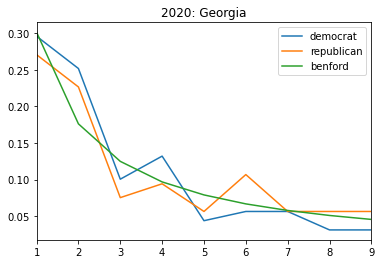

In [8]:
# select year and state to draw graph
year=2020
state='Georgia'

df_graph = get_year_state_data(data, year, state).drop('state', axis=1)
df_graph = df_graph / df_graph.sum()
df_graph = df_graph.rename({'benford_republican': 'benford'}, axis=1).drop(columns='benford_democrat', axis=1)
df_graph.plot(title=f'{year}: {state}')